### 1d-laplace demo
#### 函数库导入

In [4]:
import numpy as np
import torch
import torch.nn as nn
from basic_model import DeepModel_single, gradients
from visual_data import matplotlib_vision

import time
from tqdm import trange
import matplotlib.pyplot as plt

#### 2d-Laplace方程
求解 $u(x,y)$
$$

    \frac{\partial^2 u}{\partial^2 x} + \frac{\partial^2 u}{\partial^2 y}  = 0\\
    u(x, 1) = sin(\pi x),   u(0, y) = 0\\
    u(x, 0) = 0, u(y, 0) = 0\\
$$
其解析解为 $u(x,y)=sin(\pi x)sinh(\pi y)$

In [6]:
class Net(DeepModel_single):
    def __init__(self, planes):
        super(Net, self).__init__(planes, active=nn.Tanh())

    def equation(self, inn_var, out_var):
        duda = gradients(out_var, inn_var)
        d2udx2 = gradients(duda[..., (0,)], inn_var)[..., (0,)]
        d2udy2 = gradients(duda[..., (1,)], inn_var)[..., (1,)]
        eqs = d2udx2 + d2udy2
        return eqs

#### 数据生成

Text(0, 0.5, '$y$')

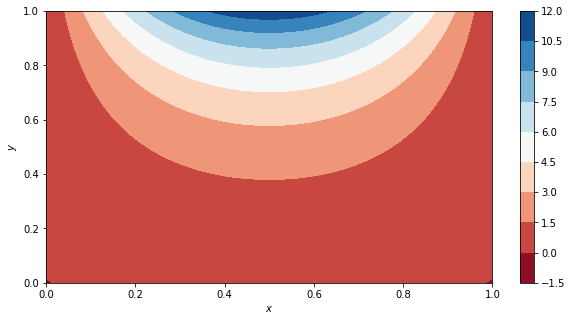

In [8]:
node_x = np.linspace(0, 1, 64, dtype=np.float32)[:, None]
node_y = np.linspace(0, 1, 64, dtype=np.float32)[:, None]

Nx, Ny = node_x.shape[0], node_y.shape[0]
node_x = np.tile(node_x, (1, node_y.shape[0]))  # Nx x Ny
node_y = np.tile(node_y, (1, node_x.shape[0])).T  # Nx x Ny

pi = np.pi
input = np.stack((node_x, node_y), axis=-1) # Nx x Ny × 2
field = (np.sin(pi*node_x) * np.sinh(pi*node_y))[..., None] # Nx x Ny × 2
# print(field.shape)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

nodes_train = torch.tensor(input, dtype=torch.float32).to(device)
field_train = torch.tensor(field, dtype=torch.float32).to(device)

plt.figure(figsize=(10, 5))
plt.contourf(node_x, node_y, field[..., 0], cmap='RdBu')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')

#### 定义训练过程

In [11]:
# 建立网络
Net_model = Net(planes=[2, 50, 50, 1],).to(device)
# 损失函数
L2loss = nn.MSELoss()
# 优化算法
Optimizer = torch.optim.Adam(Net_model.parameters(), lr=0.001, betas=(0.7, 0.9))
# 下降策略
Scheduler = torch.optim.lr_scheduler.MultiStepLR(Optimizer, milestones=[2000, 5000, 6000], gamma=0.1)
# 可视化
Visual = matplotlib_vision('/', input_name=('x', 'y'), field_name=('f',))

def train(inn_var, bounds, out_true, model, Loss, optimizer, scheduler, log_loss):

    def closure():

        optimizer.zero_grad()
        out_var = model(inn_var)
        res_i = model.equation(inn_var, out_var)
        bcs_loss_l11 = Loss(out_var[0, :], out_true[0, :])
        bcs_loss_l21 = Loss(out_var[-1, :], out_true[-1, :])
        bcs_loss_l12 = Loss(out_var[:, 0], out_true[:, 0])
        bcs_loss_l22 = Loss(out_var[:, -1], out_true[:, -1])
        eqs_loss = Loss(res_i, torch.zeros_like(res_i, dtype=torch.float32))
        bcs_loss = bcs_loss_l11 + bcs_loss_l21 + bcs_loss_l12 + bcs_loss_l22
        loss_batch = bcs_loss + eqs_loss
        loss_batch.backward()

        data_loss = Loss(out_var, out_true)
        log_loss.append([eqs_loss.item(), bcs_loss.item(), data_loss.item()])

        return loss_batch

    optimizer.step(closure)
    scheduler.step()

def inference(inn_var, model):

    out_pred = model(inn_var)
    equation = model.equation(inn_var, out_pred)

    return out_pred, equation

#### 执行训练过程

In [12]:
star_time = time.time()
log_loss = []
pbar = trange(7000)

inn_var = nodes_train
inn_var.requires_grad_(True)

# Training
for iter in pbar:

    learning_rate = Optimizer.state_dict()['param_groups'][0]['lr']
    train(inn_var, [], field_train, Net_model, L2loss, Optimizer, Scheduler, log_loss)

    # if iter > 0 and iter % 200 == 0:
    # print('iter: {:6d}, lr: {:.3e}, eqs_loss: {:.3e}, dat_loss: {:.3e}, bon_loss1: {:.3e}, cost: {:.2f}'.
    #       format(iter, learning_rate, log_loss[-1][0], log_loss[-1][-1], log_loss[-1][1], time.time()-star_time))

    pbar.set_postfix({'lr': learning_rate, 'dat_loss': log_loss[-1][-1], 'cost:':  time.time()-star_time,
                      'eqs_loss': log_loss[-1][0], 'bcs_loss': log_loss[-1][1], })

100%|██████████| 7000/7000 [00:47<00:00, 148.43it/s, lr=1e-6, dat_loss=0.00731, cost:=47.2, eqs_loss=0.0664, bcs_loss=0.121]  


#### 训练过程损失可视化

Text(0.5, 1.0, 'training loss')

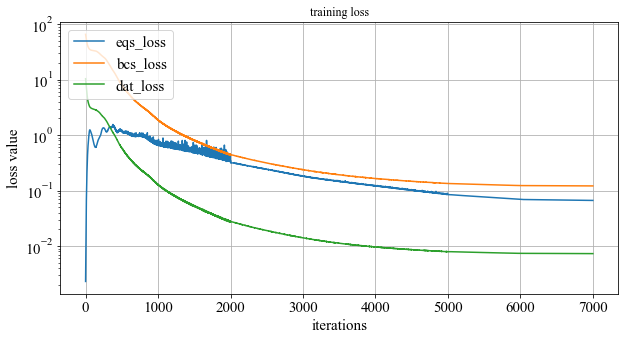

In [13]:
plt.figure(2, figsize=(10, 5))
plt.clf()
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 0], 'eqs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'bcs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, -1], 'dat_loss')
plt.title('training loss')

#### 结果对比

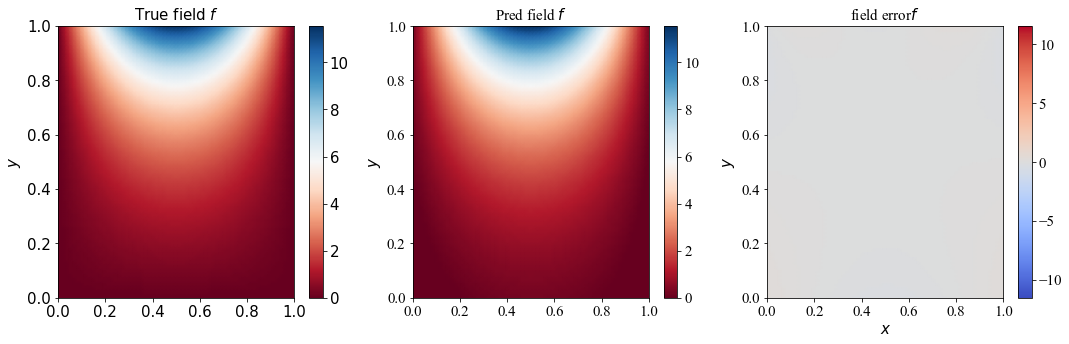

In [14]:
field_pred, equation = inference(inn_var, Net_model)

input_visual = input
field_visual_t = field
field_visual_p = field_pred.detach().cpu().numpy()

fig = plt.figure(figsize=(18, 5))
Visual.plot_fields_ms(field_visual_t, field_visual_p, input_visual)


#### 残差分布及细节对比

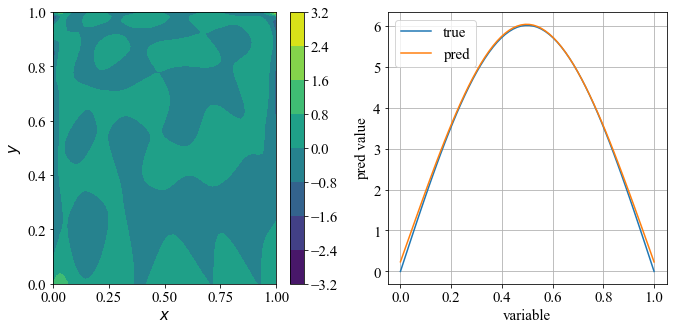

In [18]:
plt.figure(1, figsize=(11, 5))
plt.clf()
plt.subplot(121)
plt.contourf(input_visual[..., 0], input_visual[..., 1], equation[..., 0].detach().cpu().numpy())
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis()
plt.colorbar()
plt.subplot(122)
Visual.plot_value(input_visual[:, 50, 0], field_visual_t[:, 50, 0], 'true')
Visual.plot_value(input_visual[:, 50, 0], field_visual_p[:, 50, 0], 'pred')